In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import glob
import cv2
import random
import h5py
from tqdm import tqdm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Final_Project/good

/content/drive/My Drive/Final_Project/good


In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1024)
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 16

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
path_91_x2_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x2.h5"
path_set5_x2_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/Set_5/Set5_x2.h5"

path_91_x3_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x3.h5"
path_set5_x3_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/Set_5/Set5_x3.h5"

path_91_x4_train_samples_h5 = "/content/drive/My Drive/Final_Project/Images/91_set/91-image_x4.h5"
path_set5_x4_valid_samples_h5 = "/content/drive/My Drive/Final_Project/Images/Set_5/Set5_x4.h5"

In [0]:
# tf = h5py.File(path_set5_x2_valid_samples_h5, 'r')
# # df = h5py.File(deg_images_file, 'r') 
# true_images = tf['hr']['0']
# # degraded_images = np.array(tf['lr'][:])

In [0]:
# true_images.keys()

In [0]:
# plt.imshow(true_images[3])

In [0]:
class SubImagesTrainSet(Dataset):
    """Subimages dataset."""

    def __init__(self, images_path, scope = 'train'):
        images = h5py.File(images_path, 'r')
        self.true_images = np.array(images['hr'][:])
        self.deg_images = np.array(images['lr'][:])

    def __len__(self):
      return self.true_images.shape[0]
    
    def __getitem__(self, index):
      if torch.is_tensor(index):
            index = index.tolist()
      y = torch.tensor(self.true_images[index], dtype = torch.float, device = device)/255
      X = torch.tensor(self.deg_images[index], dtype = torch.float, device = device)/255
      return [torch.unsqueeze(X, dim = 2), torch.unsqueeze(y, dim = 2)]


In [0]:
class SubImagesValidSet(Dataset):
    """Subimages dataset."""

    def __init__(self, images_path, scope = 'train'):
        images = h5py.File(images_path, 'r')
        self.true_images = images['hr']
        self.deg_images = images['lr']

    def __len__(self):
      return len(self.true_images)
    
    def __getitem__(self, index):
      if torch.is_tensor(index):
            index = index.tolist()
      y = torch.tensor(np.array(self.true_images[str(index)][:]), dtype = torch.float, device = device)/255
      X = torch.tensor(np.array(self.deg_images[str(index)][:]), dtype = torch.float, device = device)/255
      return [torch.unsqueeze(X, dim = 2), torch.unsqueeze(y, dim = 2)]

In [0]:
train_dataset = SubImagesTrainSet(path_91_x3_train_samples_h5)

In [0]:
valid_dataset = SubImagesValidSet(path_set5_x3_valid_samples_h5)

In [0]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, *kwargs)

In [0]:
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = True, *kwargs)

In [0]:
def PSNR(target_image, ref_image):
  difference = torch.flatten((target_image.type(torch.float64) - ref_image.type(torch.float64)))
  mse = torch.mean(difference ** 2)
  return torch.mean(10 * torch.log10(1/mse))

In [0]:
class SRCNN(nn.Module):
  def __init__(self, num_filters_1, ker_size_1, num_filters_2, ker_size_2, ker_size_3):
    super(SRCNN, self).__init__()
    self.layer1_ = nn.Conv2d(1, num_filters_1, ker_size_1, padding=ker_size_1 // 2)
    self.layer2_ = nn.Conv2d(num_filters_1, num_filters_2, ker_size_2, padding=ker_size_2 // 2)
    self.layer3_ = nn.Conv2d(num_filters_2, 1, ker_size_3, padding=ker_size_3 // 2)
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self, X):
    X = X.permute(0, 3, 1, 2)
    X = self.relu(self.layer1_(X))
    X = self.relu(self.layer2_(X))
    X = self.layer3_(X)
    X = X.permute(0, 2, 3, 1)
    return X

In [0]:
num_fil_1 = 64
ker_1 = 9
num_fil_2 = 32
ker_2 = 3
ker_3 = 5

lr = 1e-4

Model = SRCNN(num_fil_1, ker_1, num_fil_2, ker_2, ker_3).to(device)

In [0]:
#architecture
print(Model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in Model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(Model):,} trainable parameters')

SRCNN(
  (layer1_): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (layer2_): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer3_): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)
The model has 24,513 trainable parameters


In [0]:
optimizer = optim.Adam([
                {'params': Model.layer1_.parameters()},
                {'params': Model.layer2_.parameters()},
                {'params': Model.layer3_.parameters(), 'lr': lr * 0.1}
            ], lr=lr)

criterion = torch.nn.MSELoss()

In [0]:
def train_model(model, train_iterator, optimizer, criterion, epoch):
  epoch_loss = 0
  epoch_PSNR = 0  
  #set the model in training phase
  model.train()  
  it = 0  
  with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size),leave = True, position=0) as t:
    t.set_description('epoch: {}/{}'.format(epoch, NUM_EPOCHS - 1))   

    for degraded_images, true_images in train_iterator:
      #resets the gradients after every batch
      optimizer.zero_grad()  
          
      #convert to 1D tensor
      predictied_images = model(degraded_images)
      #true_images = true_images[:, :predictied_images.shape[1], :predictied_images.shape[2], :]  
          
      #compute the loss
      loss = criterion(predictied_images, true_images)        
          
      #backpropage the loss and compute the gradients
      loss.backward()       
          
      #update the weights
      optimizer.step()  

      #compute the PSNR
      psnr = PSNR(predictied_images, true_images)       
          
      #loss and accuracy
      epoch_loss += loss.item()  
      epoch_PSNR += psnr.item()   
      it += 1

      t.set_postfix(loss='{:.6f}'.format(epoch_loss / it))
      t.update(len(true_images)) 
        
  return epoch_loss / len(train_iterator), epoch_PSNR / len(train_iterator)

In [0]:
def evaluate(model, valid_iterator, criterion):
    
  #initialize every epoch
  epoch_loss = 0
  epoch_PSNR = 0

  #deactivating dropout layers
  model.eval()
    
  #deactivates autograd
  with torch.no_grad():
    
    for degraded_images, true_images in valid_iterator:
            
      #convert to 1d tensor
      predictied_images = model(degraded_images).clamp(0.0, 1.0) 

      #compute loss and psnr
      loss = criterion(predictied_images, true_images)
      psnr = PSNR(predictied_images, true_images)
            
      #keep track of loss and psnr
      epoch_loss += loss.item()
      epoch_PSNR += psnr.item()
        
  return epoch_loss / len(valid_iterator), epoch_PSNR / len(valid_iterator)

In [0]:
def plot_loss(loss, label, color='blue'):
    plt.plot(loss, label=label, color=color)
    plt.legend()

In [0]:
# epoch_loss = 0
# with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
#   t.set_description('epoch: {}/{}'.format(1, 300 - 1)) 
#   for degraded_images, true_images in train_loader:
#     # #resets the gradients after every batch
#     # optimizer.zero_grad()  
        
#     # #convert to 1D tensor
#     # predictied_images = model(degraded_images)
#     # #true_images = true_images[:, :predictied_images.shape[1], :predictied_images.shape[2], :]  
        
#     # #compute the loss
#     # loss = criterion(predictied_images, true_images)        
        
#     # #backpropage the loss and compute the gradients
#     # loss.backward()       
        
#     # #update the weights
#     # optimizer.step()  

#     # #compute the PSNR
#     # psnr = PSNR(predictied_images, true_images)       
        
#     # #loss and accuracy
#     # epoch_loss += loss.item()  
#     # epoch_PSNR += psnr.item()   
#     epoch_loss += 1
#   # t.set_postfix(loss='{:.6f}'.format(epoch_loss))
#   # print(len(true_images))
#     t.update(16) 

In [0]:
# with tqdm(total=100, leave = True, position=0) as pbar:
#     for i in range(10):
#         time.sleep(0.1)
#         pbar.update(10)

epoch: 0/299: : 21884it [01:31, 238.01it/s, loss=0.001172]                         
epoch: 1/299:   0%|          | 32/21872 [00:00<01:43, 211.51it/s, loss=0.000834]

	Train Loss: 0.299 | Train Acc: 29.63 db
	 Val. Loss: 0.160 |  Val. Acc: 33.08 db


epoch: 1/299: : 21884it [01:34, 232.19it/s, loss=0.001172]
epoch: 2/299:   0%|          | 32/21872 [00:00<01:28, 246.87it/s, loss=0.001262]

	Train Loss: 0.299 | Train Acc: 29.63 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 2/299: : 21884it [01:35, 229.94it/s, loss=0.001173]
epoch: 3/299:   0%|          | 32/21872 [00:00<01:28, 247.28it/s, loss=0.001046]

	Train Loss: 0.299 | Train Acc: 29.62 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 3/299: : 21884it [01:35, 228.51it/s, loss=0.001172]
epoch: 4/299:   0%|          | 32/21872 [00:00<01:30, 241.65it/s, loss=0.001400]

	Train Loss: 0.299 | Train Acc: 29.61 db
	 Val. Loss: 0.161 |  Val. Acc: 33.04 db


epoch: 4/299: : 21884it [01:33, 233.67it/s, loss=0.001172]
epoch: 5/299:   0%|          | 32/21872 [00:00<01:23, 261.30it/s, loss=0.001104]

	Train Loss: 0.299 | Train Acc: 29.64 db
	 Val. Loss: 0.160 |  Val. Acc: 33.06 db


epoch: 5/299: : 21884it [01:28, 246.24it/s, loss=0.001171]
epoch: 6/299:   0%|          | 32/21872 [00:00<01:21, 269.17it/s, loss=0.001155]

	Train Loss: 0.299 | Train Acc: 29.61 db
	 Val. Loss: 0.161 |  Val. Acc: 33.05 db


epoch: 6/299: : 21884it [01:29, 245.81it/s, loss=0.001171]
epoch: 7/299:   0%|          | 32/21872 [00:00<01:25, 254.27it/s, loss=0.000805]

	Train Loss: 0.299 | Train Acc: 29.60 db
	 Val. Loss: 0.161 |  Val. Acc: 33.04 db


epoch: 7/299: : 21884it [01:28, 248.15it/s, loss=0.001171]
epoch: 8/299:   0%|          | 32/21872 [00:00<01:25, 255.78it/s, loss=0.000858]

	Train Loss: 0.299 | Train Acc: 29.63 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 8/299: : 21884it [01:29, 245.79it/s, loss=0.001171]
epoch: 9/299:   0%|          | 32/21872 [00:00<01:24, 257.40it/s, loss=0.000745]

	Train Loss: 0.299 | Train Acc: 29.61 db
	 Val. Loss: 0.162 |  Val. Acc: 33.03 db


epoch: 9/299: : 21884it [01:30, 242.29it/s, loss=0.001171]
epoch: 10/299:   0%|          | 32/21872 [00:00<01:35, 228.16it/s, loss=0.001161]

	Train Loss: 0.299 | Train Acc: 29.61 db
	 Val. Loss: 0.160 |  Val. Acc: 33.08 db


epoch: 10/299: : 21884it [01:32, 237.16it/s, loss=0.001170]
epoch: 11/299:   0%|          | 32/21872 [00:00<01:31, 238.78it/s, loss=0.001302]

	Train Loss: 0.298 | Train Acc: 29.64 db
	 Val. Loss: 0.161 |  Val. Acc: 33.06 db


epoch: 11/299: : 21884it [01:31, 239.43it/s, loss=0.001171]
epoch: 12/299:   0%|          | 32/21872 [00:00<01:24, 259.34it/s, loss=0.001008]

	Train Loss: 0.299 | Train Acc: 29.63 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 12/299: : 21884it [01:32, 237.72it/s, loss=0.001170]
epoch: 13/299:   0%|          | 32/21872 [00:00<01:26, 252.32it/s, loss=0.000859]

	Train Loss: 0.298 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.08 db


epoch: 13/299: : 21884it [01:32, 236.23it/s, loss=0.001170]
epoch: 14/299:   0%|          | 32/21872 [00:00<01:26, 251.81it/s, loss=0.001740]

	Train Loss: 0.298 | Train Acc: 29.60 db
	 Val. Loss: 0.161 |  Val. Acc: 33.04 db


epoch: 14/299: : 21884it [01:34, 230.79it/s, loss=0.001170]
epoch: 15/299:   0%|          | 32/21872 [00:00<01:36, 225.71it/s, loss=0.001442]

	Train Loss: 0.298 | Train Acc: 29.60 db
	 Val. Loss: 0.161 |  Val. Acc: 33.06 db


epoch: 15/299: : 21884it [01:35, 228.97it/s, loss=0.001170]
epoch: 16/299:   0%|          | 32/21872 [00:00<01:37, 224.39it/s, loss=0.000875]

	Train Loss: 0.298 | Train Acc: 29.62 db
	 Val. Loss: 0.159 |  Val. Acc: 33.06 db


epoch: 16/299: : 21884it [01:35, 228.50it/s, loss=0.001170]
epoch: 17/299:   0%|          | 32/21872 [00:00<01:33, 233.45it/s, loss=0.000700]

	Train Loss: 0.298 | Train Acc: 29.61 db
	 Val. Loss: 0.161 |  Val. Acc: 33.05 db


epoch: 17/299: : 21884it [01:35, 230.13it/s, loss=0.001169]
epoch: 18/299:   0%|          | 32/21872 [00:00<01:58, 184.34it/s, loss=0.000955]

	Train Loss: 0.298 | Train Acc: 29.61 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 18/299: : 21884it [01:35, 229.93it/s, loss=0.001169]
epoch: 19/299:   0%|          | 32/21872 [00:00<01:40, 216.99it/s, loss=0.000818]

	Train Loss: 0.298 | Train Acc: 29.62 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 19/299: : 21884it [01:30, 241.16it/s, loss=0.001169]
epoch: 20/299:   0%|          | 32/21872 [00:00<01:38, 220.90it/s, loss=0.000825]

	Train Loss: 0.298 | Train Acc: 29.62 db
	 Val. Loss: 0.160 |  Val. Acc: 33.09 db


epoch: 20/299: : 21884it [01:28, 246.01it/s, loss=0.001169]
epoch: 21/299:   0%|          | 32/21872 [00:00<01:25, 254.20it/s, loss=0.001570]

	Train Loss: 0.298 | Train Acc: 29.64 db
	 Val. Loss: 0.160 |  Val. Acc: 33.04 db


epoch: 21/299: : 21884it [01:28, 246.27it/s, loss=0.001169]
epoch: 22/299:   0%|          | 32/21872 [00:00<01:43, 211.49it/s, loss=0.001492]

	Train Loss: 0.298 | Train Acc: 29.62 db
	 Val. Loss: 0.160 |  Val. Acc: 33.08 db


epoch: 22/299: : 21884it [01:28, 246.29it/s, loss=0.001168]
epoch: 23/299:   0%|          | 32/21872 [00:00<01:34, 230.62it/s, loss=0.000916]

	Train Loss: 0.298 | Train Acc: 29.62 db
	 Val. Loss: 0.160 |  Val. Acc: 33.08 db


epoch: 23/299: : 21884it [01:29, 245.23it/s, loss=0.001168]
epoch: 24/299:   0%|          | 32/21872 [00:00<01:27, 248.69it/s, loss=0.001616]

	Train Loss: 0.298 | Train Acc: 29.63 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 24/299: : 21884it [01:29, 245.40it/s, loss=0.001168]
epoch: 25/299:   0%|          | 32/21872 [00:00<01:23, 262.82it/s, loss=0.000959]

	Train Loss: 0.298 | Train Acc: 29.63 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 25/299: : 21884it [01:28, 248.21it/s, loss=0.001167]
epoch: 26/299:   0%|          | 32/21872 [00:00<01:36, 226.11it/s, loss=0.001535]

	Train Loss: 0.298 | Train Acc: 29.62 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 26/299: : 21884it [01:28, 248.37it/s, loss=0.001167]
epoch: 27/299:   0%|          | 32/21872 [00:00<01:33, 234.08it/s, loss=0.000984]

	Train Loss: 0.298 | Train Acc: 29.63 db
	 Val. Loss: 0.159 |  Val. Acc: 33.06 db


epoch: 27/299: : 21884it [01:28, 246.62it/s, loss=0.001168]
epoch: 28/299:   0%|          | 32/21872 [00:00<01:21, 267.71it/s, loss=0.001275]

	Train Loss: 0.298 | Train Acc: 29.64 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 28/299: : 21884it [01:28, 248.19it/s, loss=0.001167]
epoch: 29/299:   0%|          | 32/21872 [00:00<01:41, 215.44it/s, loss=0.001303]

	Train Loss: 0.298 | Train Acc: 29.61 db
	 Val. Loss: 0.161 |  Val. Acc: 33.00 db


epoch: 29/299: : 21884it [01:27, 249.07it/s, loss=0.001167]
epoch: 30/299:   0%|          | 32/21872 [00:00<01:26, 252.25it/s, loss=0.000982]

	Train Loss: 0.297 | Train Acc: 29.63 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 30/299: : 21884it [01:26, 252.48it/s, loss=0.001167]
epoch: 31/299:   0%|          | 32/21872 [00:00<01:29, 243.65it/s, loss=0.001255]

	Train Loss: 0.298 | Train Acc: 29.63 db
	 Val. Loss: 0.159 |  Val. Acc: 33.10 db


epoch: 31/299: : 21884it [01:27, 250.58it/s, loss=0.001166]
epoch: 32/299:   0%|          | 32/21872 [00:00<01:41, 215.43it/s, loss=0.001541]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.09 db


epoch: 32/299: : 21884it [01:25, 255.45it/s, loss=0.001166]
epoch: 33/299:   0%|          | 32/21872 [00:00<01:21, 268.60it/s, loss=0.001248]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 33/299: : 21884it [01:27, 249.12it/s, loss=0.001166]
epoch: 34/299:   0%|          | 32/21872 [00:00<01:33, 232.95it/s, loss=0.001193]

	Train Loss: 0.297 | Train Acc: 29.63 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 34/299: : 21884it [01:27, 250.41it/s, loss=0.001166]
epoch: 35/299:   0%|          | 32/21872 [00:00<01:21, 269.27it/s, loss=0.001240]

	Train Loss: 0.297 | Train Acc: 29.64 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 35/299: : 21884it [01:28, 247.08it/s, loss=0.001166]
epoch: 36/299:   0%|          | 32/21872 [00:00<01:23, 261.69it/s, loss=0.000925]

	Train Loss: 0.297 | Train Acc: 29.64 db
	 Val. Loss: 0.160 |  Val. Acc: 33.06 db


epoch: 36/299: : 21884it [01:29, 243.60it/s, loss=0.001166]
epoch: 37/299:   0%|          | 32/21872 [00:00<01:25, 256.10it/s, loss=0.000912]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 37/299: : 21884it [01:27, 250.60it/s, loss=0.001166]
epoch: 38/299:   0%|          | 32/21872 [00:00<01:32, 237.26it/s, loss=0.001174]

	Train Loss: 0.297 | Train Acc: 29.66 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 38/299: : 21884it [01:26, 253.82it/s, loss=0.001165]
epoch: 39/299:   0%|          | 32/21872 [00:00<01:22, 264.97it/s, loss=0.001334]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.07 db


epoch: 39/299: : 21884it [01:26, 252.59it/s, loss=0.001165]
epoch: 40/299:   0%|          | 32/21872 [00:00<01:22, 264.21it/s, loss=0.001116]

	Train Loss: 0.297 | Train Acc: 29.64 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 40/299: : 21884it [01:27, 249.21it/s, loss=0.001165]
epoch: 41/299:   0%|          | 32/21872 [00:00<01:33, 233.96it/s, loss=0.000857]

	Train Loss: 0.297 | Train Acc: 29.64 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 41/299: : 21884it [01:28, 247.01it/s, loss=0.001165]
epoch: 42/299:   0%|          | 32/21872 [00:00<01:34, 230.29it/s, loss=0.001091]

	Train Loss: 0.297 | Train Acc: 29.62 db
	 Val. Loss: 0.159 |  Val. Acc: 33.06 db


epoch: 42/299: : 21884it [01:28, 246.02it/s, loss=0.001164]
epoch: 43/299:   0%|          | 32/21872 [00:00<01:22, 264.79it/s, loss=0.001243]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.159 |  Val. Acc: 33.07 db


epoch: 43/299: : 21884it [01:28, 247.25it/s, loss=0.001165]
epoch: 44/299:   0%|          | 32/21872 [00:00<01:22, 266.05it/s, loss=0.000898]

	Train Loss: 0.297 | Train Acc: 29.64 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 44/299: : 21884it [01:27, 249.29it/s, loss=0.001164]
epoch: 45/299:   0%|          | 32/21872 [00:00<01:21, 269.57it/s, loss=0.001384]

	Train Loss: 0.297 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.08 db


epoch: 45/299: : 21884it [01:27, 249.85it/s, loss=0.001164]
epoch: 46/299:   0%|          | 32/21872 [00:00<01:30, 241.76it/s, loss=0.002114]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.05 db


epoch: 46/299: : 21884it [01:27, 249.61it/s, loss=0.001164]
epoch: 47/299:   0%|          | 32/21872 [00:00<01:22, 263.23it/s, loss=0.001253]

	Train Loss: 0.297 | Train Acc: 29.66 db
	 Val. Loss: 0.159 |  Val. Acc: 33.05 db


epoch: 47/299: : 21884it [01:28, 247.02it/s, loss=0.001164]
epoch: 48/299:   0%|          | 32/21872 [00:00<01:32, 237.36it/s, loss=0.000852]

	Train Loss: 0.297 | Train Acc: 29.64 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 48/299: : 21884it [01:27, 250.39it/s, loss=0.001164]
epoch: 49/299:   0%|          | 32/21872 [00:00<01:29, 242.78it/s, loss=0.001154]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 49/299: : 21884it [01:28, 247.22it/s, loss=0.001163]
epoch: 50/299:   0%|          | 32/21872 [00:00<01:33, 234.09it/s, loss=0.000957]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.03 db


epoch: 50/299: : 21884it [01:28, 246.88it/s, loss=0.001163]
epoch: 51/299:   0%|          | 32/21872 [00:00<01:22, 266.02it/s, loss=0.000969]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 51/299: : 21884it [01:28, 248.46it/s, loss=0.001164]
epoch: 52/299:   0%|          | 16/21872 [00:00<02:29, 145.80it/s, loss=0.000759]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.04 db


epoch: 52/299: : 21884it [01:27, 248.95it/s, loss=0.001163]                         
epoch: 53/299:   0%|          | 32/21872 [00:00<01:34, 231.91it/s, loss=0.001019]

	Train Loss: 0.297 | Train Acc: 29.64 db
	 Val. Loss: 0.158 |  Val. Acc: 33.07 db


epoch: 53/299: : 21884it [01:28, 247.15it/s, loss=0.001163]
epoch: 54/299:   0%|          | 32/21872 [00:00<01:32, 236.97it/s, loss=0.001860]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 54/299: : 21884it [01:28, 247.02it/s, loss=0.001163]
epoch: 55/299:   0%|          | 32/21872 [00:00<01:25, 254.21it/s, loss=0.001292]

	Train Loss: 0.297 | Train Acc: 29.66 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 55/299: : 21884it [01:27, 248.95it/s, loss=0.001163]
epoch: 56/299:   0%|          | 32/21872 [00:00<01:38, 221.94it/s, loss=0.000831]

	Train Loss: 0.297 | Train Acc: 29.65 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 56/299: : 21884it [01:26, 251.54it/s, loss=0.001162]
epoch: 57/299:   0%|          | 32/21872 [00:00<01:32, 236.59it/s, loss=0.001322]

	Train Loss: 0.296 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 57/299: : 21884it [01:28, 246.19it/s, loss=0.001162]
epoch: 58/299:   0%|          | 32/21872 [00:00<01:21, 268.13it/s, loss=0.000936]

	Train Loss: 0.296 | Train Acc: 29.65 db
	 Val. Loss: 0.158 |  Val. Acc: 33.08 db


epoch: 58/299: : 21884it [01:27, 250.85it/s, loss=0.001162]
epoch: 59/299:   0%|          | 32/21872 [00:00<01:23, 260.66it/s, loss=0.001379]

	Train Loss: 0.296 | Train Acc: 29.66 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 59/299: : 21884it [01:27, 250.60it/s, loss=0.001162]
epoch: 60/299:   0%|          | 32/21872 [00:00<01:27, 250.48it/s, loss=0.001062]

	Train Loss: 0.296 | Train Acc: 29.63 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 60/299: : 21884it [01:27, 249.85it/s, loss=0.001162]
epoch: 61/299:   0%|          | 32/21872 [00:00<01:35, 229.01it/s, loss=0.001334]

	Train Loss: 0.296 | Train Acc: 29.66 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 61/299: : 21884it [01:28, 246.06it/s, loss=0.001162]
epoch: 62/299:   0%|          | 32/21872 [00:00<01:40, 217.73it/s, loss=0.000824]

	Train Loss: 0.296 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 62/299: : 21884it [01:28, 246.50it/s, loss=0.001161]
epoch: 63/299:   0%|          | 32/21872 [00:00<01:23, 263.12it/s, loss=0.001258]

	Train Loss: 0.296 | Train Acc: 29.67 db
	 Val. Loss: 0.159 |  Val. Acc: 33.10 db


epoch: 63/299: : 21884it [01:28, 247.63it/s, loss=0.001161]
epoch: 64/299:   0%|          | 32/21872 [00:00<01:27, 250.49it/s, loss=0.001094]

	Train Loss: 0.296 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.10 db


epoch: 64/299: : 21884it [01:28, 247.60it/s, loss=0.001161]
epoch: 65/299:   0%|          | 32/21872 [00:00<01:22, 263.15it/s, loss=0.001212]

	Train Loss: 0.296 | Train Acc: 29.68 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 65/299: : 21884it [01:28, 246.17it/s, loss=0.001161]
epoch: 66/299:   0%|          | 32/21872 [00:00<01:26, 252.98it/s, loss=0.001827]

	Train Loss: 0.296 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 66/299: : 21884it [01:30, 241.08it/s, loss=0.001161]
epoch: 67/299:   0%|          | 32/21872 [00:00<01:26, 252.90it/s, loss=0.001046]

	Train Loss: 0.296 | Train Acc: 29.65 db
	 Val. Loss: 0.159 |  Val. Acc: 33.07 db


epoch: 67/299: : 21884it [01:27, 249.51it/s, loss=0.001161]
epoch: 68/299:   0%|          | 32/21872 [00:00<01:25, 255.40it/s, loss=0.000792]

	Train Loss: 0.296 | Train Acc: 29.65 db
	 Val. Loss: 0.160 |  Val. Acc: 33.01 db


epoch: 68/299: : 21884it [01:28, 248.25it/s, loss=0.001161]
epoch: 69/299:   0%|          | 32/21872 [00:00<01:24, 257.60it/s, loss=0.001096]

	Train Loss: 0.296 | Train Acc: 29.66 db
	 Val. Loss: 0.159 |  Val. Acc: 33.08 db


epoch: 69/299: : 21884it [01:28, 246.28it/s, loss=0.001160]
epoch: 70/299:   0%|          | 32/21872 [00:00<01:25, 255.98it/s, loss=0.001061]

	Train Loss: 0.296 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.11 db


epoch: 70/299: : 21884it [01:28, 246.31it/s, loss=0.001160]
epoch: 71/299:   0%|          | 32/21872 [00:00<01:21, 267.17it/s, loss=0.001300]

	Train Loss: 0.296 | Train Acc: 29.65 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 71/299: : 21884it [01:27, 250.98it/s, loss=0.001160]
epoch: 72/299:   0%|          | 32/21872 [00:00<01:40, 217.46it/s, loss=0.000768]

	Train Loss: 0.296 | Train Acc: 29.66 db
	 Val. Loss: 0.159 |  Val. Acc: 33.12 db


epoch: 72/299: : 21884it [01:27, 250.44it/s, loss=0.001160]
epoch: 73/299:   0%|          | 32/21872 [00:00<01:24, 257.11it/s, loss=0.001759]

	Train Loss: 0.296 | Train Acc: 29.65 db
	 Val. Loss: 0.158 |  Val. Acc: 33.10 db


epoch: 73/299: : 21884it [01:27, 250.09it/s, loss=0.001160]
epoch: 74/299:   0%|          | 32/21872 [00:00<01:22, 263.49it/s, loss=0.001094]

	Train Loss: 0.296 | Train Acc: 29.64 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 74/299: : 21884it [01:27, 249.10it/s, loss=0.001160]
epoch: 75/299:   0%|          | 32/21872 [00:00<01:23, 261.32it/s, loss=0.000911]

	Train Loss: 0.296 | Train Acc: 29.65 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 75/299: : 21884it [01:26, 251.83it/s, loss=0.001160]
epoch: 76/299:   0%|          | 32/21872 [00:00<01:38, 221.09it/s, loss=0.001600]

	Train Loss: 0.296 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 76/299: : 21884it [01:28, 246.87it/s, loss=0.001159]
epoch: 77/299:   0%|          | 32/21872 [00:00<01:33, 234.33it/s, loss=0.000847]

	Train Loss: 0.296 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.07 db


epoch: 77/299: : 21884it [01:27, 249.91it/s, loss=0.001160]
epoch: 78/299:   0%|          | 32/21872 [00:00<01:28, 247.96it/s, loss=0.001188]

	Train Loss: 0.296 | Train Acc: 29.66 db
	 Val. Loss: 0.157 |  Val. Acc: 33.14 db


epoch: 78/299: : 21884it [01:28, 248.14it/s, loss=0.001159]
epoch: 79/299:   0%|          | 32/21872 [00:00<01:22, 264.85it/s, loss=0.001257]

	Train Loss: 0.296 | Train Acc: 29.66 db
	 Val. Loss: 0.159 |  Val. Acc: 33.12 db


epoch: 79/299: : 21884it [01:28, 247.34it/s, loss=0.001159]
epoch: 80/299:   0%|          | 32/21872 [00:00<01:25, 256.58it/s, loss=0.001110]

	Train Loss: 0.296 | Train Acc: 29.66 db
	 Val. Loss: 0.158 |  Val. Acc: 33.10 db


epoch: 80/299: : 21884it [01:27, 250.00it/s, loss=0.001159]
epoch: 81/299:   0%|          | 32/21872 [00:00<01:36, 227.07it/s, loss=0.001120]

	Train Loss: 0.296 | Train Acc: 29.64 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 81/299: : 21884it [01:27, 248.94it/s, loss=0.001159]
epoch: 82/299:   0%|          | 32/21872 [00:00<01:23, 261.81it/s, loss=0.000887]

	Train Loss: 0.296 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 82/299: : 21884it [01:28, 246.92it/s, loss=0.001159]
epoch: 83/299:   0%|          | 32/21872 [00:00<01:28, 246.78it/s, loss=0.001475]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.159 |  Val. Acc: 33.06 db


epoch: 83/299: : 21884it [01:29, 244.10it/s, loss=0.001159]
epoch: 84/299:   0%|          | 32/21872 [00:00<01:23, 262.38it/s, loss=0.001127]

	Train Loss: 0.295 | Train Acc: 29.66 db
	 Val. Loss: 0.157 |  Val. Acc: 33.11 db


epoch: 84/299: : 21884it [01:29, 245.27it/s, loss=0.001158]
epoch: 85/299:   0%|          | 32/21872 [00:00<01:22, 263.91it/s, loss=0.000918]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 85/299: : 21884it [01:27, 249.29it/s, loss=0.001158]
epoch: 86/299:   0%|          | 32/21872 [00:00<01:23, 262.67it/s, loss=0.001075]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.160 |  Val. Acc: 33.03 db


epoch: 86/299: : 21884it [01:28, 248.32it/s, loss=0.001158]
epoch: 87/299:   0%|          | 32/21872 [00:00<01:42, 212.69it/s, loss=0.001193]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.159 |  Val. Acc: 33.09 db


epoch: 87/299: : 21884it [01:28, 247.82it/s, loss=0.001158]
epoch: 88/299:   0%|          | 32/21872 [00:00<01:27, 250.42it/s, loss=0.001078]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 88/299: : 21884it [01:29, 244.93it/s, loss=0.001158]
epoch: 89/299:   0%|          | 32/21872 [00:00<01:37, 223.59it/s, loss=0.001013]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 89/299: : 21884it [01:30, 241.59it/s, loss=0.001157]                         
epoch: 90/299:   0%|          | 32/21872 [00:00<01:28, 246.63it/s, loss=0.001742]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 90/299: : 21884it [01:29, 245.00it/s, loss=0.001158]
epoch: 91/299:   0%|          | 32/21872 [00:00<01:33, 233.52it/s, loss=0.001101]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.08 db


epoch: 91/299: : 21884it [01:29, 243.60it/s, loss=0.001158]
epoch: 92/299:   0%|          | 32/21872 [00:00<01:26, 253.05it/s, loss=0.000845]

	Train Loss: 0.295 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 92/299: : 21884it [01:29, 243.31it/s, loss=0.001157]
epoch: 93/299:   0%|          | 32/21872 [00:00<01:28, 245.92it/s, loss=0.001269]

	Train Loss: 0.295 | Train Acc: 29.69 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 93/299: : 21884it [01:30, 241.91it/s, loss=0.001157]
epoch: 94/299:   0%|          | 32/21872 [00:00<01:35, 228.64it/s, loss=0.000941]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 94/299: : 21884it [01:29, 244.81it/s, loss=0.001157]
epoch: 95/299:   0%|          | 32/21872 [00:00<01:26, 252.40it/s, loss=0.001319]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.10 db


epoch: 95/299: : 21884it [01:29, 243.91it/s, loss=0.001157]
epoch: 96/299:   0%|          | 32/21872 [00:00<01:28, 248.07it/s, loss=0.000821]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.10 db


epoch: 96/299: : 21884it [01:29, 243.47it/s, loss=0.001157]
epoch: 97/299:   0%|          | 32/21872 [00:00<01:23, 260.35it/s, loss=0.001274]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 97/299: : 21884it [01:28, 246.04it/s, loss=0.001157]
epoch: 98/299:   0%|          | 32/21872 [00:00<01:26, 253.68it/s, loss=0.001175]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 98/299: : 21884it [01:28, 245.95it/s, loss=0.001156]
epoch: 99/299:   0%|          | 32/21872 [00:00<01:31, 237.94it/s, loss=0.000834]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.14 db


epoch: 99/299: : 21884it [01:29, 244.40it/s, loss=0.001156]
epoch: 100/299:   0%|          | 32/21872 [00:00<01:26, 252.32it/s, loss=0.001242]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.06 db


epoch: 100/299: : 21884it [01:29, 244.01it/s, loss=0.001157]
epoch: 101/299:   0%|          | 32/21872 [00:00<01:25, 255.95it/s, loss=0.001404]

	Train Loss: 0.295 | Train Acc: 29.69 db
	 Val. Loss: 0.159 |  Val. Acc: 33.07 db


epoch: 101/299: : 21884it [01:29, 243.42it/s, loss=0.001157]
epoch: 102/299:   0%|          | 32/21872 [00:00<01:24, 257.24it/s, loss=0.001034]

	Train Loss: 0.295 | Train Acc: 29.66 db
	 Val. Loss: 0.158 |  Val. Acc: 33.08 db


epoch: 102/299: : 21884it [01:29, 245.60it/s, loss=0.001156]
epoch: 103/299:   0%|          | 32/21872 [00:00<01:25, 254.42it/s, loss=0.001047]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.13 db


epoch: 103/299: : 21884it [01:29, 243.88it/s, loss=0.001156]
epoch: 104/299:   0%|          | 32/21872 [00:00<01:24, 258.38it/s, loss=0.001022]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.09 db


epoch: 104/299: : 21884it [01:29, 244.70it/s, loss=0.001156]
epoch: 105/299:   0%|          | 32/21872 [00:00<01:38, 221.57it/s, loss=0.001707]

	Train Loss: 0.295 | Train Acc: 29.69 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 105/299: : 21884it [01:29, 245.24it/s, loss=0.001156]
epoch: 106/299:   0%|          | 32/21872 [00:00<01:25, 254.88it/s, loss=0.000975]

	Train Loss: 0.295 | Train Acc: 29.69 db
	 Val. Loss: 0.158 |  Val. Acc: 33.08 db


epoch: 106/299: : 21884it [01:29, 243.67it/s, loss=0.001155]
epoch: 107/299:   0%|          | 32/21872 [00:00<01:46, 205.19it/s, loss=0.000979]

	Train Loss: 0.295 | Train Acc: 29.69 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 107/299: : 21884it [01:29, 245.07it/s, loss=0.001155]
epoch: 108/299:   0%|          | 32/21872 [00:00<01:25, 255.97it/s, loss=0.001167]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 108/299: : 21884it [01:29, 245.08it/s, loss=0.001155]
epoch: 109/299:   0%|          | 32/21872 [00:00<01:39, 219.15it/s, loss=0.000894]

	Train Loss: 0.295 | Train Acc: 29.67 db
	 Val. Loss: 0.159 |  Val. Acc: 33.07 db


epoch: 109/299: : 21884it [01:29, 244.76it/s, loss=0.001155]
epoch: 110/299:   0%|          | 32/21872 [00:00<01:25, 256.04it/s, loss=0.001276]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 110/299: : 21884it [01:29, 244.51it/s, loss=0.001155]
epoch: 111/299:   0%|          | 32/21872 [00:00<01:28, 246.75it/s, loss=0.001076]

	Train Loss: 0.295 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 111/299: : 21884it [01:29, 244.55it/s, loss=0.001155]
epoch: 112/299:   0%|          | 32/21872 [00:00<01:35, 228.09it/s, loss=0.001432]

	Train Loss: 0.295 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 112/299: : 21884it [01:29, 243.90it/s, loss=0.001155]
epoch: 113/299:   0%|          | 32/21872 [00:00<01:23, 262.39it/s, loss=0.000631]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 113/299: : 21884it [01:29, 244.63it/s, loss=0.001155]
epoch: 114/299:   0%|          | 32/21872 [00:00<01:22, 264.20it/s, loss=0.001166]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.10 db


epoch: 114/299: : 21884it [01:28, 246.30it/s, loss=0.001155]
epoch: 115/299:   0%|          | 32/21872 [00:00<01:23, 261.74it/s, loss=0.001435]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.10 db


epoch: 115/299: : 21884it [01:28, 247.36it/s, loss=0.001155]
epoch: 116/299:   0%|          | 32/21872 [00:00<01:29, 244.21it/s, loss=0.001651]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 116/299: : 21884it [01:29, 244.31it/s, loss=0.001154]
epoch: 117/299:   0%|          | 32/21872 [00:00<01:24, 257.22it/s, loss=0.001743]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 117/299: : 21884it [01:30, 242.77it/s, loss=0.001154]                         
epoch: 118/299:   0%|          | 32/21872 [00:00<01:27, 250.33it/s, loss=0.001048]

	Train Loss: 0.294 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.10 db


epoch: 118/299: : 21884it [01:28, 247.61it/s, loss=0.001155]
epoch: 119/299:   0%|          | 32/21872 [00:00<01:30, 241.46it/s, loss=0.001282]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.14 db


epoch: 119/299: : 21884it [01:28, 245.91it/s, loss=0.001154]
epoch: 120/299:   0%|          | 32/21872 [00:00<01:21, 269.44it/s, loss=0.000965]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 120/299: : 21884it [01:28, 245.90it/s, loss=0.001154]
epoch: 121/299:   0%|          | 32/21872 [00:00<01:22, 263.50it/s, loss=0.000828]

	Train Loss: 0.294 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 121/299: : 21884it [01:28, 246.32it/s, loss=0.001154]
epoch: 122/299:   0%|          | 32/21872 [00:00<01:24, 259.31it/s, loss=0.001374]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 122/299: : 21884it [01:28, 246.91it/s, loss=0.001153]
epoch: 123/299:   0%|          | 32/21872 [00:00<01:27, 251.00it/s, loss=0.001053]

	Train Loss: 0.294 | Train Acc: 29.67 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 123/299: : 21884it [01:29, 244.90it/s, loss=0.001154]
epoch: 124/299:   0%|          | 32/21872 [00:00<01:24, 257.71it/s, loss=0.001023]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 124/299: : 21884it [01:29, 245.84it/s, loss=0.001153]
epoch: 125/299:   0%|          | 32/21872 [00:00<01:22, 265.60it/s, loss=0.001070]

	Train Loss: 0.294 | Train Acc: 29.70 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 125/299: : 21884it [01:28, 246.00it/s, loss=0.001153]
epoch: 126/299:   0%|          | 32/21872 [00:00<01:21, 268.43it/s, loss=0.001059]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 126/299: : 21884it [01:28, 246.37it/s, loss=0.001153]
epoch: 127/299:   0%|          | 32/21872 [00:00<01:30, 241.27it/s, loss=0.001110]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 127/299: : 21884it [01:29, 243.34it/s, loss=0.001153]
epoch: 128/299:   0%|          | 16/21872 [00:00<02:31, 144.29it/s, loss=0.001039]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.157 |  Val. Acc: 33.11 db


epoch: 128/299: : 21884it [01:29, 243.90it/s, loss=0.001153]
epoch: 129/299:   0%|          | 32/21872 [00:00<01:29, 243.73it/s, loss=0.001564]

	Train Loss: 0.294 | Train Acc: 29.70 db
	 Val. Loss: 0.157 |  Val. Acc: 33.14 db


epoch: 129/299: : 21884it [01:29, 244.28it/s, loss=0.001153]
epoch: 130/299:   0%|          | 32/21872 [00:00<01:22, 263.89it/s, loss=0.000803]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.158 |  Val. Acc: 33.08 db


epoch: 130/299: : 21884it [01:29, 243.72it/s, loss=0.001153]
epoch: 131/299:   0%|          | 32/21872 [00:00<01:32, 237.29it/s, loss=0.000909]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 131/299: : 21884it [01:28, 246.40it/s, loss=0.001153]
epoch: 132/299:   0%|          | 32/21872 [00:00<01:32, 237.39it/s, loss=0.000880]

	Train Loss: 0.294 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 132/299: : 21884it [01:29, 245.35it/s, loss=0.001153]
epoch: 133/299:   0%|          | 32/21872 [00:00<01:21, 267.16it/s, loss=0.000888]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.15 db


epoch: 133/299: : 21884it [01:28, 246.18it/s, loss=0.001152]
epoch: 134/299:   0%|          | 32/21872 [00:00<01:25, 255.02it/s, loss=0.000715]

	Train Loss: 0.294 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.15 db


epoch: 134/299: : 21884it [01:29, 244.16it/s, loss=0.001152]
epoch: 135/299:   0%|          | 32/21872 [00:00<01:43, 211.79it/s, loss=0.001069]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.12 db


epoch: 135/299: : 21884it [01:29, 245.05it/s, loss=0.001152]
epoch: 136/299:   0%|          | 32/21872 [00:00<01:23, 261.20it/s, loss=0.001138]

	Train Loss: 0.294 | Train Acc: 29.67 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 136/299: : 21884it [01:29, 244.79it/s, loss=0.001152]
epoch: 137/299:   0%|          | 32/21872 [00:00<01:26, 253.22it/s, loss=0.001124]

	Train Loss: 0.294 | Train Acc: 29.68 db
	 Val. Loss: 0.158 |  Val. Acc: 33.07 db


epoch: 137/299: : 21884it [01:29, 243.41it/s, loss=0.001152]
epoch: 138/299:   0%|          | 32/21872 [00:00<01:22, 263.75it/s, loss=0.000969]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 138/299: : 21884it [01:30, 242.41it/s, loss=0.001152]
epoch: 139/299:   0%|          | 32/21872 [00:00<01:27, 248.62it/s, loss=0.000921]

	Train Loss: 0.294 | Train Acc: 29.70 db
	 Val. Loss: 0.157 |  Val. Acc: 33.14 db


epoch: 139/299: : 21884it [01:29, 243.47it/s, loss=0.001152]
epoch: 140/299:   0%|          | 32/21872 [00:00<01:21, 268.03it/s, loss=0.000697]

	Train Loss: 0.294 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 140/299: : 21884it [01:28, 246.32it/s, loss=0.001152]
epoch: 141/299:   0%|          | 32/21872 [00:00<01:27, 249.05it/s, loss=0.001011]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.12 db


epoch: 141/299: : 21884it [01:30, 242.68it/s, loss=0.001151]
epoch: 142/299:   0%|          | 32/21872 [00:00<01:27, 248.57it/s, loss=0.000676]

	Train Loss: 0.294 | Train Acc: 29.70 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 142/299: : 21884it [01:29, 243.85it/s, loss=0.001152]
epoch: 143/299:   0%|          | 32/21872 [00:00<01:24, 259.36it/s, loss=0.001068]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.158 |  Val. Acc: 33.12 db


epoch: 143/299: : 21884it [01:29, 244.01it/s, loss=0.001151]
epoch: 144/299:   0%|          | 32/21872 [00:00<01:30, 241.15it/s, loss=0.000890]

	Train Loss: 0.294 | Train Acc: 29.67 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 144/299: : 21884it [01:30, 242.20it/s, loss=0.001152]
epoch: 145/299:   0%|          | 32/21872 [00:00<01:26, 251.12it/s, loss=0.001164]

	Train Loss: 0.294 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 145/299: : 21884it [01:29, 244.91it/s, loss=0.001151]
epoch: 146/299:   0%|          | 32/21872 [00:00<01:37, 222.88it/s, loss=0.001497]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 146/299: : 21884it [01:29, 243.34it/s, loss=0.001151]
epoch: 147/299:   0%|          | 32/21872 [00:00<01:28, 247.82it/s, loss=0.000854]

	Train Loss: 0.294 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 147/299: : 21884it [01:30, 241.29it/s, loss=0.001151]
epoch: 148/299:   0%|          | 32/21872 [00:00<01:26, 251.77it/s, loss=0.001268]

	Train Loss: 0.294 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.17 db


epoch: 148/299: : 21884it [01:30, 243.01it/s, loss=0.001151]
epoch: 149/299:   0%|          | 32/21872 [00:00<01:38, 221.30it/s, loss=0.000952]

	Train Loss: 0.293 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 149/299: : 21884it [01:30, 242.17it/s, loss=0.001151]
epoch: 150/299:   0%|          | 32/21872 [00:00<01:41, 215.93it/s, loss=0.001045]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 150/299: : 21884it [01:30, 241.96it/s, loss=0.001151]
epoch: 151/299:   0%|          | 32/21872 [00:00<01:24, 258.07it/s, loss=0.000837]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 151/299: : 21884it [01:29, 244.71it/s, loss=0.001150]
epoch: 152/299:   0%|          | 32/21872 [00:00<01:24, 259.63it/s, loss=0.001117]

	Train Loss: 0.293 | Train Acc: 29.67 db
	 Val. Loss: 0.157 |  Val. Acc: 33.14 db


epoch: 152/299: : 21884it [01:29, 245.45it/s, loss=0.001150]
epoch: 153/299:   0%|          | 32/21872 [00:00<01:34, 230.24it/s, loss=0.001722]

	Train Loss: 0.293 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 153/299: : 21884it [01:29, 244.05it/s, loss=0.001150]
epoch: 154/299:   0%|          | 32/21872 [00:00<01:25, 256.68it/s, loss=0.001202]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 154/299: : 21884it [01:30, 242.97it/s, loss=0.001150]
epoch: 155/299:   0%|          | 32/21872 [00:00<01:44, 208.77it/s, loss=0.001099]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.15 db


epoch: 155/299: : 21884it [01:31, 239.26it/s, loss=0.001150]
epoch: 156/299:   0%|          | 32/21872 [00:00<01:44, 208.20it/s, loss=0.001264]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.159 |  Val. Acc: 33.04 db


epoch: 156/299: : 21884it [01:31, 240.16it/s, loss=0.001150]
epoch: 157/299:   0%|          | 32/21872 [00:00<01:31, 239.92it/s, loss=0.000752]

	Train Loss: 0.293 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 157/299: : 21884it [01:31, 238.57it/s, loss=0.001150]
epoch: 158/299:   0%|          | 32/21872 [00:00<01:32, 237.26it/s, loss=0.001242]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.157 |  Val. Acc: 33.14 db


epoch: 158/299: : 21884it [01:31, 239.09it/s, loss=0.001150]
epoch: 159/299:   0%|          | 32/21872 [00:00<01:41, 215.01it/s, loss=0.001203]

	Train Loss: 0.293 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 159/299: : 21884it [01:30, 240.92it/s, loss=0.001150]
epoch: 160/299:   0%|          | 32/21872 [00:00<01:29, 243.74it/s, loss=0.000776]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 160/299: : 21884it [01:30, 241.38it/s, loss=0.001150]
epoch: 161/299:   0%|          | 32/21872 [00:00<01:27, 248.62it/s, loss=0.000850]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 161/299: : 21884it [01:31, 239.36it/s, loss=0.001150]
epoch: 162/299:   0%|          | 32/21872 [00:00<01:25, 256.27it/s, loss=0.000966]

	Train Loss: 0.293 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 162/299: : 21884it [01:30, 241.28it/s, loss=0.001149]
epoch: 163/299:   0%|          | 32/21872 [00:00<01:24, 259.98it/s, loss=0.000911]

	Train Loss: 0.293 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 163/299: : 21884it [01:30, 242.03it/s, loss=0.001150]
epoch: 164/299:   0%|          | 32/21872 [00:00<01:31, 239.33it/s, loss=0.001243]

	Train Loss: 0.293 | Train Acc: 29.72 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 164/299: : 21884it [01:30, 241.83it/s, loss=0.001149]
epoch: 165/299:   0%|          | 32/21872 [00:00<01:36, 227.47it/s, loss=0.001616]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 165/299: : 21884it [01:30, 242.70it/s, loss=0.001149]
epoch: 166/299:   0%|          | 32/21872 [00:00<01:36, 225.31it/s, loss=0.000985]

	Train Loss: 0.293 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 166/299: : 21884it [01:29, 244.94it/s, loss=0.001149]
epoch: 167/299:   0%|          | 32/21872 [00:00<01:47, 204.03it/s, loss=0.001191]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.158 |  Val. Acc: 33.11 db


epoch: 167/299: : 21884it [01:30, 241.49it/s, loss=0.001149]
epoch: 168/299:   0%|          | 32/21872 [00:00<01:24, 257.17it/s, loss=0.001139]

	Train Loss: 0.293 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 168/299: : 21884it [01:32, 237.86it/s, loss=0.001149]
epoch: 169/299:   0%|          | 32/21872 [00:00<01:23, 262.51it/s, loss=0.000980]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 169/299: : 21884it [01:30, 241.39it/s, loss=0.001149]
epoch: 170/299:   0%|          | 32/21872 [00:00<01:25, 256.51it/s, loss=0.001878]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 170/299: : 21884it [01:30, 242.94it/s, loss=0.001149]
epoch: 171/299:   0%|          | 32/21872 [00:00<01:24, 259.58it/s, loss=0.001752]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 171/299: : 21884it [01:29, 244.35it/s, loss=0.001148]
epoch: 172/299:   0%|          | 32/21872 [00:00<01:29, 244.42it/s, loss=0.000907]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.156 |  Val. Acc: 33.11 db


epoch: 172/299: : 21884it [01:29, 243.42it/s, loss=0.001149]
epoch: 173/299:   0%|          | 32/21872 [00:00<01:25, 254.04it/s, loss=0.001045]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 173/299: : 21884it [01:30, 242.80it/s, loss=0.001148]
epoch: 174/299:   0%|          | 32/21872 [00:00<01:30, 240.87it/s, loss=0.000961]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 174/299: : 21884it [01:30, 242.77it/s, loss=0.001148]
epoch: 175/299:   0%|          | 32/21872 [00:00<01:23, 261.85it/s, loss=0.001102]

	Train Loss: 0.293 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 175/299: : 21884it [01:30, 242.97it/s, loss=0.001148]
epoch: 176/299:   0%|          | 32/21872 [00:00<01:23, 262.40it/s, loss=0.001139]

	Train Loss: 0.293 | Train Acc: 29.69 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 176/299: : 21884it [01:29, 244.16it/s, loss=0.001148]
epoch: 177/299:   0%|          | 32/21872 [00:00<01:28, 245.72it/s, loss=0.001357]

	Train Loss: 0.293 | Train Acc: 29.69 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 177/299: : 21884it [01:29, 245.26it/s, loss=0.001148]
epoch: 178/299:   0%|          | 32/21872 [00:00<01:23, 260.56it/s, loss=0.001388]

	Train Loss: 0.293 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 178/299: : 21884it [01:33, 234.40it/s, loss=0.001148]
epoch: 179/299:   0%|          | 32/21872 [00:00<01:22, 264.41it/s, loss=0.000709]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 179/299: : 21884it [01:29, 245.70it/s, loss=0.001148]
epoch: 180/299:   0%|          | 32/21872 [00:00<01:23, 261.53it/s, loss=0.001243]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 180/299: : 21884it [01:29, 244.32it/s, loss=0.001148]
epoch: 181/299:   0%|          | 32/21872 [00:00<01:31, 238.73it/s, loss=0.000818]

	Train Loss: 0.293 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 181/299: : 21884it [01:28, 246.34it/s, loss=0.001147]
epoch: 182/299:   0%|          | 32/21872 [00:00<01:33, 232.59it/s, loss=0.001163]

	Train Loss: 0.293 | Train Acc: 29.72 db
	 Val. Loss: 0.157 |  Val. Acc: 33.07 db


epoch: 182/299: : 21884it [01:30, 241.08it/s, loss=0.001147]
epoch: 183/299:   0%|          | 32/21872 [00:00<01:40, 217.56it/s, loss=0.000901]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 183/299: : 21884it [01:30, 242.21it/s, loss=0.001148]
epoch: 184/299:   0%|          | 32/21872 [00:00<01:26, 253.41it/s, loss=0.001255]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 184/299: : 21884it [01:31, 240.13it/s, loss=0.001147]
epoch: 185/299:   0%|          | 32/21872 [00:00<01:23, 260.94it/s, loss=0.001343]

	Train Loss: 0.293 | Train Acc: 29.73 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 185/299: : 21884it [01:31, 239.10it/s, loss=0.001147]
epoch: 186/299:   0%|          | 32/21872 [00:00<01:36, 226.71it/s, loss=0.001212]

	Train Loss: 0.293 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 186/299: : 21884it [01:30, 241.46it/s, loss=0.001147]
epoch: 187/299:   0%|          | 32/21872 [00:00<01:30, 242.09it/s, loss=0.001241]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 187/299: : 21884it [01:30, 240.70it/s, loss=0.001147]
epoch: 188/299:   0%|          | 32/21872 [00:00<01:30, 241.94it/s, loss=0.001345]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 188/299: : 21884it [01:31, 239.57it/s, loss=0.001147]
epoch: 189/299:   0%|          | 32/21872 [00:00<01:33, 234.24it/s, loss=0.002267]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 189/299: : 21884it [01:31, 239.17it/s, loss=0.001147]
epoch: 190/299:   0%|          | 32/21872 [00:00<01:24, 257.37it/s, loss=0.000970]

	Train Loss: 0.293 | Train Acc: 29.71 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 190/299: : 21884it [01:30, 242.88it/s, loss=0.001147]
epoch: 191/299:   0%|          | 32/21872 [00:00<01:25, 255.01it/s, loss=0.001566]

	Train Loss: 0.293 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 191/299: : 21884it [01:29, 243.21it/s, loss=0.001147]
epoch: 192/299:   0%|          | 32/21872 [00:00<01:33, 232.74it/s, loss=0.001074]

	Train Loss: 0.292 | Train Acc: 29.70 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 192/299: : 21884it [01:29, 244.92it/s, loss=0.001147]
epoch: 193/299:   0%|          | 32/21872 [00:00<01:22, 264.45it/s, loss=0.001093]

	Train Loss: 0.292 | Train Acc: 29.71 db
	 Val. Loss: 0.155 |  Val. Acc: 33.19 db


epoch: 193/299: : 21884it [01:30, 242.36it/s, loss=0.001146]
epoch: 194/299:   0%|          | 32/21872 [00:00<01:23, 260.25it/s, loss=0.000917]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 194/299: : 21884it [01:30, 242.47it/s, loss=0.001147]
epoch: 195/299:   0%|          | 32/21872 [00:00<01:39, 220.53it/s, loss=0.001750]

	Train Loss: 0.292 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 195/299: : 21884it [01:30, 242.90it/s, loss=0.001147]
epoch: 196/299:   0%|          | 32/21872 [00:00<01:26, 253.73it/s, loss=0.001011]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 196/299: : 21884it [01:30, 241.75it/s, loss=0.001147]
epoch: 197/299:   0%|          | 32/21872 [00:00<01:27, 250.37it/s, loss=0.001018]

	Train Loss: 0.292 | Train Acc: 29.71 db
	 Val. Loss: 0.156 |  Val. Acc: 33.17 db


epoch: 197/299: : 21884it [01:30, 243.08it/s, loss=0.001146]
epoch: 198/299:   0%|          | 32/21872 [00:00<01:24, 258.01it/s, loss=0.001072]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 198/299: : 21884it [01:30, 240.86it/s, loss=0.001146]
epoch: 199/299:   0%|          | 32/21872 [00:00<01:23, 261.61it/s, loss=0.000957]

	Train Loss: 0.292 | Train Acc: 29.70 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 199/299: : 21884it [01:30, 242.44it/s, loss=0.001146]
epoch: 200/299:   0%|          | 32/21872 [00:00<01:36, 225.71it/s, loss=0.001281]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.157 |  Val. Acc: 33.09 db


epoch: 200/299: : 21884it [01:30, 242.37it/s, loss=0.001146]
epoch: 201/299:   0%|          | 32/21872 [00:00<01:25, 255.28it/s, loss=0.001282]

	Train Loss: 0.292 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 201/299: : 21884it [01:29, 244.88it/s, loss=0.001146]
epoch: 202/299:   0%|          | 32/21872 [00:00<01:35, 228.19it/s, loss=0.001509]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 202/299: : 21884it [01:30, 241.11it/s, loss=0.001146]
epoch: 203/299:   0%|          | 32/21872 [00:00<01:25, 254.13it/s, loss=0.000930]

	Train Loss: 0.292 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 203/299: : 21884it [01:30, 240.79it/s, loss=0.001146]
epoch: 204/299:   0%|          | 32/21872 [00:00<01:42, 213.96it/s, loss=0.001163]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 204/299: : 21884it [01:29, 243.94it/s, loss=0.001146]
epoch: 205/299:   0%|          | 32/21872 [00:00<01:22, 263.73it/s, loss=0.001107]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.157 |  Val. Acc: 33.11 db


epoch: 205/299: : 21884it [01:29, 243.66it/s, loss=0.001146]
epoch: 206/299:   0%|          | 32/21872 [00:00<01:25, 256.67it/s, loss=0.001054]

	Train Loss: 0.292 | Train Acc: 29.71 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 206/299: : 21884it [01:31, 238.62it/s, loss=0.001146]
epoch: 207/299:   0%|          | 32/21872 [00:00<01:36, 226.91it/s, loss=0.001128]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.157 |  Val. Acc: 33.12 db


epoch: 207/299: : 21884it [01:31, 239.36it/s, loss=0.001145]
epoch: 208/299:   0%|          | 32/21872 [00:00<01:22, 266.12it/s, loss=0.001241]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.157 |  Val. Acc: 33.15 db


epoch: 208/299: : 21884it [01:33, 234.07it/s, loss=0.001145]
epoch: 209/299:   0%|          | 32/21872 [00:00<01:31, 238.49it/s, loss=0.000974]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 209/299: : 21884it [01:30, 242.32it/s, loss=0.001145]
epoch: 210/299:   0%|          | 32/21872 [00:00<01:43, 211.66it/s, loss=0.001345]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 210/299: : 21884it [01:31, 239.98it/s, loss=0.001145]
epoch: 211/299:   0%|          | 32/21872 [00:00<01:25, 256.24it/s, loss=0.001202]

	Train Loss: 0.292 | Train Acc: 29.71 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 211/299: : 21884it [01:30, 240.51it/s, loss=0.001145]
epoch: 212/299:   0%|          | 32/21872 [00:00<01:31, 238.14it/s, loss=0.000933]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.11 db


epoch: 212/299: : 21884it [01:30, 241.46it/s, loss=0.001145]
epoch: 213/299:   0%|          | 32/21872 [00:00<01:39, 219.99it/s, loss=0.000847]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 213/299: : 21884it [01:31, 238.48it/s, loss=0.001145]
epoch: 214/299:   0%|          | 32/21872 [00:00<01:45, 207.50it/s, loss=0.001205]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 214/299: : 21884it [01:30, 241.70it/s, loss=0.001145]
epoch: 215/299:   0%|          | 32/21872 [00:00<01:30, 240.15it/s, loss=0.001218]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 215/299: : 21884it [01:30, 242.11it/s, loss=0.001145]
epoch: 216/299:   0%|          | 32/21872 [00:00<01:24, 257.27it/s, loss=0.001147]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 216/299: : 21884it [01:30, 240.92it/s, loss=0.001145]
epoch: 217/299:   0%|          | 32/21872 [00:00<01:23, 261.71it/s, loss=0.001159]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.157 |  Val. Acc: 33.10 db


epoch: 217/299: : 21884it [01:29, 243.26it/s, loss=0.001145]
epoch: 218/299:   0%|          | 32/21872 [00:00<01:46, 204.67it/s, loss=0.001112]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 218/299: : 21884it [01:31, 240.19it/s, loss=0.001145]
epoch: 219/299:   0%|          | 32/21872 [00:00<01:26, 252.24it/s, loss=0.001327]

	Train Loss: 0.292 | Train Acc: 29.71 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 219/299: : 21884it [01:30, 241.03it/s, loss=0.001145]
epoch: 220/299:   0%|          | 32/21872 [00:00<01:33, 233.77it/s, loss=0.000901]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 220/299: : 21884it [01:29, 243.21it/s, loss=0.001145]
epoch: 221/299:   0%|          | 32/21872 [00:00<01:27, 250.10it/s, loss=0.001350]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 221/299: : 21884it [01:30, 242.88it/s, loss=0.001144]
epoch: 222/299:   0%|          | 32/21872 [00:00<01:30, 241.91it/s, loss=0.000999]

	Train Loss: 0.292 | Train Acc: 29.70 db
	 Val. Loss: 0.156 |  Val. Acc: 33.12 db


epoch: 222/299: : 21884it [01:30, 241.87it/s, loss=0.001145]
epoch: 223/299:   0%|          | 32/21872 [00:00<01:22, 266.28it/s, loss=0.000816]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 223/299: : 21884it [01:30, 240.61it/s, loss=0.001144]
epoch: 224/299:   0%|          | 32/21872 [00:00<01:24, 259.43it/s, loss=0.001289]

	Train Loss: 0.292 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 224/299: : 21884it [01:31, 239.38it/s, loss=0.001144]
epoch: 225/299:   0%|          | 32/21872 [00:00<01:42, 212.88it/s, loss=0.000747]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 225/299: : 21884it [01:33, 233.59it/s, loss=0.001144]
epoch: 226/299:   0%|          | 32/21872 [00:00<01:35, 229.55it/s, loss=0.000956]

	Train Loss: 0.292 | Train Acc: 29.72 db
	 Val. Loss: 0.154 |  Val. Acc: 33.19 db


epoch: 226/299: : 21884it [01:32, 237.77it/s, loss=0.001144]
epoch: 227/299:   0%|          | 32/21872 [00:00<01:42, 212.18it/s, loss=0.001082]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.19 db


epoch: 227/299: : 21884it [01:31, 238.80it/s, loss=0.001144]
epoch: 228/299:   0%|          | 32/21872 [00:00<01:29, 244.28it/s, loss=0.000819]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 228/299: : 21884it [01:32, 236.57it/s, loss=0.001144]
epoch: 229/299:   0%|          | 32/21872 [00:00<01:28, 247.77it/s, loss=0.000787]

	Train Loss: 0.292 | Train Acc: 29.70 db
	 Val. Loss: 0.154 |  Val. Acc: 33.17 db


epoch: 229/299: : 21884it [01:32, 235.82it/s, loss=0.001144]
epoch: 230/299:   0%|          | 32/21872 [00:00<01:34, 231.31it/s, loss=0.000953]

	Train Loss: 0.292 | Train Acc: 29.75 db
	 Val. Loss: 0.156 |  Val. Acc: 33.12 db


epoch: 230/299: : 21884it [01:30, 240.61it/s, loss=0.001144]
epoch: 231/299:   0%|          | 32/21872 [00:00<01:28, 248.14it/s, loss=0.001313]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.12 db


epoch: 231/299: : 21884it [01:30, 241.78it/s, loss=0.001143]
epoch: 232/299:   0%|          | 32/21872 [00:00<01:38, 220.74it/s, loss=0.001544]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.16 db


epoch: 232/299: : 21884it [01:30, 241.18it/s, loss=0.001144]
epoch: 233/299:   0%|          | 32/21872 [00:00<01:31, 239.02it/s, loss=0.001279]

	Train Loss: 0.292 | Train Acc: 29.75 db
	 Val. Loss: 0.157 |  Val. Acc: 33.13 db


epoch: 233/299: : 21884it [01:30, 242.24it/s, loss=0.001143]
epoch: 234/299:   0%|          | 32/21872 [00:00<01:40, 217.81it/s, loss=0.001063]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 234/299: : 21884it [01:30, 242.11it/s, loss=0.001143]
epoch: 235/299:   0%|          | 32/21872 [00:00<01:29, 244.92it/s, loss=0.000914]

	Train Loss: 0.292 | Train Acc: 29.74 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 235/299: : 21884it [01:30, 242.38it/s, loss=0.001143]
epoch: 236/299:   0%|          | 32/21872 [00:00<01:35, 227.55it/s, loss=0.001132]

	Train Loss: 0.292 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.14 db


epoch: 236/299: : 21884it [01:30, 240.59it/s, loss=0.001143]
epoch: 237/299:   0%|          | 32/21872 [00:00<01:27, 248.89it/s, loss=0.000819]

	Train Loss: 0.292 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.18 db


epoch: 237/299: : 21884it [01:31, 240.27it/s, loss=0.001143]
epoch: 238/299:   0%|          | 32/21872 [00:00<01:40, 218.14it/s, loss=0.001019]

	Train Loss: 0.292 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 238/299: : 21884it [01:30, 242.05it/s, loss=0.001143]
epoch: 239/299:   0%|          | 32/21872 [00:00<01:27, 248.69it/s, loss=0.001122]

	Train Loss: 0.292 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 239/299: : 21884it [01:32, 237.52it/s, loss=0.001143]
epoch: 240/299:   0%|          | 32/21872 [00:00<01:36, 225.29it/s, loss=0.000952]

	Train Loss: 0.292 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 240/299: : 21884it [01:29, 243.23it/s, loss=0.001143]
epoch: 241/299:   0%|          | 32/21872 [00:00<01:29, 244.66it/s, loss=0.000960]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 241/299: : 21884it [01:29, 245.56it/s, loss=0.001143]
epoch: 242/299:   0%|          | 32/21872 [00:00<01:37, 224.16it/s, loss=0.001013]

	Train Loss: 0.291 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 242/299: : 21884it [01:30, 242.85it/s, loss=0.001142]
epoch: 243/299:   0%|          | 32/21872 [00:00<01:45, 206.89it/s, loss=0.001198]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 243/299: : 21884it [01:29, 243.92it/s, loss=0.001143]
epoch: 244/299:   0%|          | 32/21872 [00:00<01:34, 230.64it/s, loss=0.001750]

	Train Loss: 0.291 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 244/299: : 21884it [01:30, 243.11it/s, loss=0.001143]
epoch: 245/299:   0%|          | 32/21872 [00:00<01:38, 221.55it/s, loss=0.001068]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 245/299: : 21884it [01:29, 243.24it/s, loss=0.001143]
epoch: 246/299:   0%|          | 32/21872 [00:00<01:25, 256.78it/s, loss=0.000797]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 246/299: : 21884it [01:28, 246.03it/s, loss=0.001142]
epoch: 247/299:   0%|          | 32/21872 [00:00<01:22, 263.30it/s, loss=0.001167]

	Train Loss: 0.291 | Train Acc: 29.71 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 247/299: : 21884it [01:30, 241.76it/s, loss=0.001143]
epoch: 248/299:   0%|          | 32/21872 [00:00<01:30, 240.47it/s, loss=0.000867]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.156 |  Val. Acc: 33.17 db


epoch: 248/299: : 21884it [01:29, 245.51it/s, loss=0.001142]
epoch: 249/299:   0%|          | 32/21872 [00:00<01:24, 258.72it/s, loss=0.000791]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 249/299: : 21884it [01:30, 240.80it/s, loss=0.001142]
epoch: 250/299:   0%|          | 32/21872 [00:00<01:26, 251.11it/s, loss=0.000911]

	Train Loss: 0.291 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.11 db


epoch: 250/299: : 21884it [01:30, 242.22it/s, loss=0.001142]
epoch: 251/299:   0%|          | 32/21872 [00:00<01:24, 258.28it/s, loss=0.001122]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 251/299: : 21884it [01:29, 245.09it/s, loss=0.001142]
epoch: 252/299:   0%|          | 32/21872 [00:00<01:27, 248.91it/s, loss=0.000934]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 252/299: : 21884it [01:30, 242.89it/s, loss=0.001142]
epoch: 253/299:   0%|          | 32/21872 [00:00<01:49, 198.73it/s, loss=0.001275]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 253/299: : 21884it [01:30, 242.12it/s, loss=0.001142]
epoch: 254/299:   0%|          | 32/21872 [00:00<01:26, 251.05it/s, loss=0.000927]

	Train Loss: 0.291 | Train Acc: 29.71 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 254/299: : 21884it [01:31, 240.21it/s, loss=0.001142]
epoch: 255/299:   0%|          | 32/21872 [00:00<01:26, 253.81it/s, loss=0.001133]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 255/299: : 21884it [01:31, 238.76it/s, loss=0.001142]
epoch: 256/299:   0%|          | 32/21872 [00:00<01:24, 259.67it/s, loss=0.001368]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 256/299: : 21884it [01:30, 241.31it/s, loss=0.001142]
epoch: 257/299:   0%|          | 32/21872 [00:00<01:24, 258.78it/s, loss=0.001400]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.14 db


epoch: 257/299: : 21884it [01:30, 241.22it/s, loss=0.001142]
epoch: 258/299:   0%|          | 32/21872 [00:00<01:25, 256.68it/s, loss=0.001069]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 258/299: : 21884it [01:30, 240.55it/s, loss=0.001142]
epoch: 259/299:   0%|          | 32/21872 [00:00<01:25, 256.61it/s, loss=0.000883]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.11 db


epoch: 259/299: : 21884it [01:31, 240.47it/s, loss=0.001141]
epoch: 260/299:   0%|          | 32/21872 [00:00<01:23, 261.77it/s, loss=0.001093]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 260/299: : 21884it [01:31, 239.68it/s, loss=0.001141]
epoch: 261/299:   0%|          | 32/21872 [00:00<01:30, 241.57it/s, loss=0.001265]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 261/299: : 21884it [01:32, 237.66it/s, loss=0.001141]
epoch: 262/299:   0%|          | 32/21872 [00:00<01:37, 224.98it/s, loss=0.000973]

	Train Loss: 0.291 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.12 db


epoch: 262/299: : 21884it [01:31, 239.42it/s, loss=0.001141]
epoch: 263/299:   0%|          | 32/21872 [00:00<01:38, 221.88it/s, loss=0.001278]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 263/299: : 21884it [01:29, 243.33it/s, loss=0.001141]
epoch: 264/299:   0%|          | 32/21872 [00:00<01:22, 265.43it/s, loss=0.001466]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 264/299: : 21884it [01:30, 242.31it/s, loss=0.001141]
epoch: 265/299:   0%|          | 32/21872 [00:00<01:22, 263.98it/s, loss=0.000828]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 265/299: : 21884it [01:30, 241.10it/s, loss=0.001141]
epoch: 266/299:   0%|          | 32/21872 [00:00<01:31, 239.80it/s, loss=0.001359]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 266/299: : 21884it [01:29, 243.26it/s, loss=0.001141]
epoch: 267/299:   0%|          | 32/21872 [00:00<01:21, 268.70it/s, loss=0.001202]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 267/299: : 21884it [01:29, 244.07it/s, loss=0.001141]
epoch: 268/299:   0%|          | 32/21872 [00:00<01:29, 244.43it/s, loss=0.001010]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.156 |  Val. Acc: 33.14 db


epoch: 268/299: : 21884it [01:29, 244.32it/s, loss=0.001141]
epoch: 269/299:   0%|          | 32/21872 [00:00<01:22, 264.07it/s, loss=0.000908]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 269/299: : 21884it [01:31, 239.23it/s, loss=0.001141]
epoch: 270/299:   0%|          | 32/21872 [00:00<01:23, 260.47it/s, loss=0.000623]

	Train Loss: 0.291 | Train Acc: 29.72 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 270/299: : 21884it [01:29, 244.42it/s, loss=0.001141]
epoch: 271/299:   0%|          | 32/21872 [00:00<01:36, 225.92it/s, loss=0.000871]

	Train Loss: 0.291 | Train Acc: 29.72 db
	 Val. Loss: 0.155 |  Val. Acc: 33.14 db


epoch: 271/299: : 21884it [01:30, 242.19it/s, loss=0.001141]
epoch: 272/299:   0%|          | 32/21872 [00:00<01:23, 261.61it/s, loss=0.000966]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.14 db


epoch: 272/299: : 21884it [01:29, 244.01it/s, loss=0.001141]
epoch: 273/299:   0%|          | 32/21872 [00:00<01:23, 260.72it/s, loss=0.000886]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.157 |  Val. Acc: 33.09 db


epoch: 273/299: : 21884it [01:29, 245.27it/s, loss=0.001141]
epoch: 274/299:   0%|          | 32/21872 [00:00<01:22, 263.52it/s, loss=0.001068]

	Train Loss: 0.291 | Train Acc: 29.72 db
	 Val. Loss: 0.157 |  Val. Acc: 33.08 db


epoch: 274/299: : 21884it [01:29, 243.50it/s, loss=0.001140]
epoch: 275/299:   0%|          | 32/21872 [00:00<01:21, 266.99it/s, loss=0.000966]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.18 db


epoch: 275/299: : 21884it [01:29, 244.60it/s, loss=0.001140]
epoch: 276/299:   0%|          | 32/21872 [00:00<01:37, 224.18it/s, loss=0.001151]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 276/299: : 21884it [01:30, 242.48it/s, loss=0.001140]
epoch: 277/299:   0%|          | 32/21872 [00:00<01:22, 263.58it/s, loss=0.001019]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 277/299: : 21884it [01:30, 242.91it/s, loss=0.001140]
epoch: 278/299:   0%|          | 32/21872 [00:00<01:32, 235.22it/s, loss=0.001324]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.16 db


epoch: 278/299: : 21884it [01:29, 243.85it/s, loss=0.001140]
epoch: 279/299:   0%|          | 32/21872 [00:00<01:22, 265.03it/s, loss=0.000669]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 279/299: : 21884it [01:30, 241.41it/s, loss=0.001140]
epoch: 280/299:   0%|          | 32/21872 [00:00<01:26, 251.60it/s, loss=0.001320]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.11 db


epoch: 280/299: : 21884it [01:30, 241.80it/s, loss=0.001140]
epoch: 281/299:   0%|          | 32/21872 [00:00<01:25, 255.82it/s, loss=0.000905]

	Train Loss: 0.291 | Train Acc: 29.76 db
	 Val. Loss: 0.155 |  Val. Acc: 33.18 db


epoch: 281/299: : 21884it [01:30, 241.53it/s, loss=0.001140]
epoch: 282/299:   0%|          | 32/21872 [00:00<01:40, 216.49it/s, loss=0.001094]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.18 db


epoch: 282/299: : 21884it [01:29, 245.18it/s, loss=0.001140]
epoch: 283/299:   0%|          | 32/21872 [00:00<01:28, 247.45it/s, loss=0.001001]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.154 |  Val. Acc: 33.18 db


epoch: 283/299: : 21884it [01:30, 241.01it/s, loss=0.001140]
epoch: 284/299:   0%|          | 32/21872 [00:00<01:35, 227.76it/s, loss=0.001841]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 284/299: : 21884it [01:30, 242.67it/s, loss=0.001140]
epoch: 285/299:   0%|          | 32/21872 [00:00<01:38, 220.73it/s, loss=0.001159]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.15 db


epoch: 285/299: : 21884it [01:30, 242.62it/s, loss=0.001140]
epoch: 286/299:   0%|          | 32/21872 [00:00<01:22, 264.53it/s, loss=0.000658]

	Train Loss: 0.291 | Train Acc: 29.76 db
	 Val. Loss: 0.156 |  Val. Acc: 33.13 db


epoch: 286/299: : 21884it [01:29, 244.06it/s, loss=0.001140]
epoch: 287/299:   0%|          | 32/21872 [00:00<01:30, 241.67it/s, loss=0.001167]

	Train Loss: 0.291 | Train Acc: 29.76 db
	 Val. Loss: 0.154 |  Val. Acc: 33.20 db


epoch: 287/299: : 21884it [01:29, 245.66it/s, loss=0.001139]
epoch: 288/299:   0%|          | 32/21872 [00:00<01:24, 257.66it/s, loss=0.000972]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.155 |  Val. Acc: 33.19 db


epoch: 288/299: : 21884it [01:30, 241.02it/s, loss=0.001139]
epoch: 289/299:   0%|          | 32/21872 [00:00<01:22, 264.12it/s, loss=0.000978]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.156 |  Val. Acc: 33.08 db


epoch: 289/299: : 21884it [01:29, 244.29it/s, loss=0.001139]
epoch: 290/299:   0%|          | 32/21872 [00:00<01:35, 228.85it/s, loss=0.000862]

	Train Loss: 0.290 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.19 db


epoch: 290/299: : 21884it [01:30, 241.05it/s, loss=0.001140]
epoch: 291/299:   0%|          | 32/21872 [00:00<01:23, 260.20it/s, loss=0.000891]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.154 |  Val. Acc: 33.17 db


epoch: 291/299: : 21884it [01:30, 242.40it/s, loss=0.001139]
epoch: 292/299:   0%|          | 32/21872 [00:00<01:23, 260.91it/s, loss=0.001274]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.156 |  Val. Acc: 33.12 db


epoch: 292/299: : 21884it [01:29, 244.44it/s, loss=0.001140]
epoch: 293/299:   0%|          | 32/21872 [00:00<01:23, 261.38it/s, loss=0.000711]

	Train Loss: 0.291 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.14 db


epoch: 293/299: : 21884it [01:29, 245.23it/s, loss=0.001139]
epoch: 294/299:   0%|          | 32/21872 [00:00<01:23, 262.21it/s, loss=0.001359]

	Train Loss: 0.291 | Train Acc: 29.77 db
	 Val. Loss: 0.154 |  Val. Acc: 33.18 db


epoch: 294/299: : 21884it [01:29, 243.69it/s, loss=0.001139]
epoch: 295/299:   0%|          | 32/21872 [00:00<01:23, 260.68it/s, loss=0.000905]

	Train Loss: 0.290 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.15 db


epoch: 295/299: : 21884it [01:29, 244.12it/s, loss=0.001139]
epoch: 296/299:   0%|          | 32/21872 [00:00<01:23, 260.39it/s, loss=0.000821]

	Train Loss: 0.290 | Train Acc: 29.75 db
	 Val. Loss: 0.155 |  Val. Acc: 33.18 db


epoch: 296/299: : 21884it [01:29, 244.49it/s, loss=0.001139]
epoch: 297/299:   0%|          | 32/21872 [00:00<01:48, 201.64it/s, loss=0.000945]

	Train Loss: 0.291 | Train Acc: 29.74 db
	 Val. Loss: 0.155 |  Val. Acc: 33.17 db


epoch: 297/299: : 21884it [01:29, 244.43it/s, loss=0.001139]
epoch: 298/299:   0%|          | 32/21872 [00:00<01:42, 212.98it/s, loss=0.000863]

	Train Loss: 0.290 | Train Acc: 29.74 db
	 Val. Loss: 0.154 |  Val. Acc: 33.20 db


epoch: 298/299: : 21884it [01:29, 244.14it/s, loss=0.001139]
epoch: 299/299:   0%|          | 32/21872 [00:00<01:21, 266.55it/s, loss=0.001036]

	Train Loss: 0.291 | Train Acc: 29.73 db
	 Val. Loss: 0.154 |  Val. Acc: 33.20 db


epoch: 299/299: : 21884it [01:29, 243.95it/s, loss=0.001139]


	Train Loss: 0.290 | Train Acc: 29.74 db
	 Val. Loss: 0.154 |  Val. Acc: 33.16 db


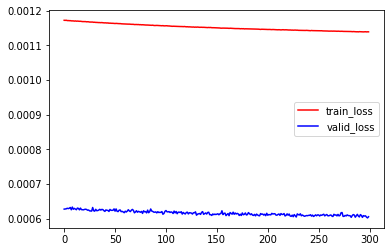

In [0]:
NUM_EPOCHS = 300
best_valid_loss = float('inf')

train_losses = []
train_psnrs = []
valid_losses = []
valid_psnrs = []

for epoch in range(NUM_EPOCHS):
     
    #train the model
    train_loss, train_psnr = train_model(Model, train_loader, optimizer, criterion, epoch)
    
    #evaluate the model
    valid_loss, valid_psnr = evaluate(Model, valid_loader, criterion)
    
    train_losses.append(train_loss)
    train_psnrs.append(train_psnr)
    valid_losses.append(valid_loss)
    valid_psnrs.append(valid_psnr)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Model.state_dict(), '/content/drive/My Drive/Final_Project/good/saved_weights_91_x3_1.pt')
    
    # print("Epoch: ", epoch)
    print(f'\tTrain Loss: {train_loss * 255:.3f} | Train Acc: {train_psnr:.2f} db')
    print(f'\t Val. Loss: {valid_loss * 255:.3f} |  Val. Acc: {valid_psnr:.2f} db')

plot_loss(train_losses,'train_loss','red')
plot_loss(valid_losses,'valid_loss',)


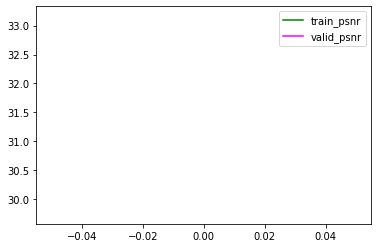

In [0]:
plot_loss(train_psnr,'train_psnr', 'green')
plot_loss(valid_psnr, 'valid_psnr', 'magenta')

In [0]:
Model.load_state_dict(torch.load('saved_weights_91_x3_1.pt'))

In [0]:
valid_loss, valid_psnr = evaluate(Model, valid_loader, criterion)
print(f'\t Val. Loss: {valid_loss * 255:.3f} |  Val. Acc: {valid_psnr:.2f} db')

	 Val. Loss: 0.160 |  Val. Acc: 33.06 db
